# K-Means 和PCA（主成分分析）

此Notebook是配合Andrew Ng "Machine Leanring"中[聚类算法](https://github.com/loveunk/machine-learning-deep-learning-notes/blob/master/machine-learning/clustering.md)和[数据降维](https://github.com/loveunk/machine-learning-deep-learning-notes/blob/master/machine-learning/dimension-reduction.md)部分学习使用。

测试用Python版本为3.6
* 机器学习路径：https://github.com/loveunk/machine-learning-deep-learning-notes/
* 内容正文综合参考网络资源，使用中如果有疑问请联络：https://www.kaikai.ai

本练习分两部分：
1. 我们将实现K-means算法应用到图片压缩上，并使用它来压缩图像。将从一个简单的2D数据集开始，以了解K-means算法应用到图片压缩上，然后我们将其应用于图像压缩。
2. 我们将对主成分分析(PCA)进行实验，并了解如何使用它来找到面部图像的低维表示。

## 1. K-means 聚类

在这部分，你将实现K-means算法，并应用到图片压缩中。

首先，你会在一个二维数据集开始实验，以获得一些直观的工作原理。
之后，你会将K-means算法应用到图片压缩上，减少图片的颜色，仅保留那些图片上最常见的颜色。

### 1.1 实现K-means算法
K-means是一个迭代的，无监督的聚类算法，将类似的实例组合成簇。 该算法通过猜测每个簇的初始聚类中心开始，然后重复将实例分配给最近的簇，并重新计算该簇的聚类中心。 

#### 1.1.1 寻找最近的中心点
要实现的第一部分是找到数据中每个实例最接近的聚类中心的函数。
对于给定的所有中心点，K-means算法把每个样本$x^{(i)}$分配给离它最近的中心点。
公式如下：

$$c^{(i)} = j \text{ that miminizes } ||x^{(i)} - \mu_j||^2$$

其中$c^{(i)}$ 是距离 $x^{(i)}$ 最近的中心点的索引， $\mu_j$是第$j$个中心点的位置（值）。

In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.io import loadmat

In [102]:
def find_closest_centroids(X, centroids):
    m = X.shape[0]
    k = centroids.shape[0]
    idx = np.zeros(m)
    
    for i in range(m):
        min_dist = 1000000
        for j in range(k):
            dist = np.sum((X[i,:] - centroids[j,:]) ** 2)
            if dist < min_dist:
                min_dist = dist
                idx[i] = j

    return idx

让我们来测试这个函数，以确保它的工作正常。 我们将使用练习中提供的测试用例。

In [103]:
data = loadmat('data/ex7data2.mat')
X = data['X']
initial_centroids = initial_centroids = np.array([[3, 3], [6, 2], [8, 5]])

idx = find_closest_centroids(X, initial_centroids)
idx[0:3]

# 如果代码没问题，预期的输出为[0., 2., 1.]

array([0., 2., 1.])

#### 1.1.2 计算聚类中心的值

接下来，我们需要一个函数来计算簇的聚类中心。 聚类中心只是当前分配给簇的所有样本的平均值。计算公式为：
$$\mu_k = \frac{1}{|C_k|}\sum_{i \in C_k} x^{(i)}$$

其中$C_k$是所有属于第$k$个聚类中心的点的集合。
例如，$x^{(3)}$ 和 $x^{(5)}$ 被分配给$k=2$的聚类中心，那么 $\mu_2 = \dfrac{1}{2}(x^{(3)} + x^{(5)})$。

下面先加载数据，绘制出来看看：

In [104]:
data2 = pd.DataFrame(data.get('X'), columns=['X1', 'X2'])

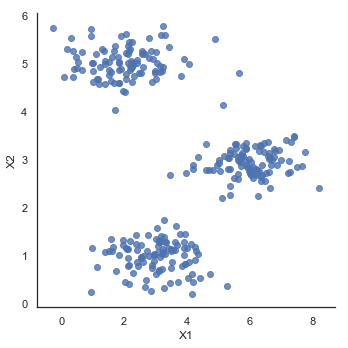

In [105]:
sb.set(context="notebook", style="white")
sb.lmplot('X1', 'X2', data=data2, fit_reg=False)
plt.show()

计算中心点的函数：

In [106]:
def compute_centroids(X, idx, k):
    m, n = X.shape
    centroids = np.zeros((k, n))
    
    for i in range(k):
        indices = np.where(idx == i)
        centroids[i,:] = (np.sum(X[indices,:], axis=1) / len(indices[0])).ravel()
    
    return centroids

In [107]:
centroids=compute_centroids(X, idx, 3)

此输出也符合练习中的预期值。

### 1.2 应用K-means到数据集上
这部分涉及实际运行该算法的一些迭代次数和可视化结果。 
为了运行算法，我们只需要在将样本分配给最近的簇并重新计算簇的聚类中心。

In [108]:
def run_k_means(X, initial_centroids, max_iters):
    m, n = X.shape
    k = initial_centroids.shape[0]
    idx = np.zeros(m)
    centroids = initial_centroids
    
    centroids_iters = []
    centroids_iters.append(centroids)
    for i in range(max_iters):
        idx = find_closest_centroids(X, centroids)
        centroids = compute_centroids(X, idx, k)
        centroids_iters.append(centroids)
    
    return idx, np.array(centroids_iters)

In [109]:
idx, centroids_iters = run_k_means(X, initial_centroids, 10)

绘制出中心点的的变化过程：

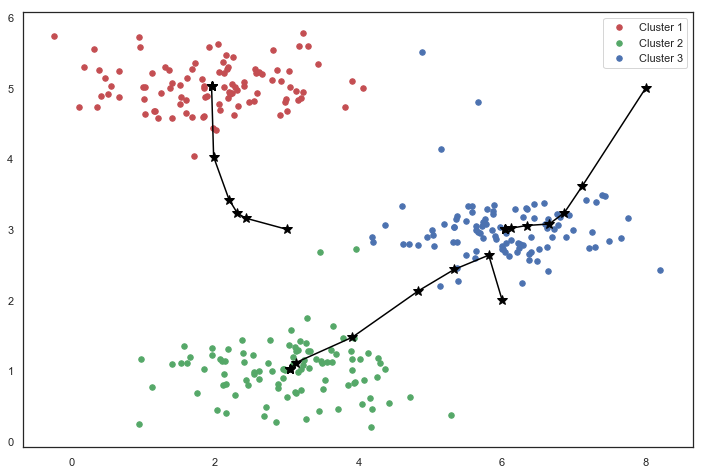

In [110]:
cluster1 = X[np.where(idx == 0)[0],:]
cluster2 = X[np.where(idx == 1)[0],:]
cluster3 = X[np.where(idx == 2)[0],:]

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(cluster1[:,0], cluster1[:,1], s=30, color='r', label='Cluster 1')
ax.scatter(cluster2[:,0], cluster2[:,1], s=30, color='g', label='Cluster 2')
ax.scatter(cluster3[:,0], cluster3[:,1], s=30, color='b', label='Cluster 3')
ax.legend()
for i in range(centroids_iters.shape[1]):
    plt.plot(centroids_iters[:,i,0], centroids_iters[:,i,1], marker='*', ms=10, color='black')
plt.show()

### 1.3 随机初始化

我们跳过的一个步骤是初始化聚类中心的过程。 这可以影响算法的收敛。 我们的任务是创建一个选择随机样本并将其用作初始聚类中心的函数。

In [111]:
def init_centroids(X, k):
    m, n = X.shape
    centroids = np.zeros((k, n))
    idx = np.random.randint(0, m, k)
    
    for i in range(k):
        centroids[i,:] = X[idx[i],:]
    
    return centroids

In [112]:
init_centroids(X, 3)

array([[3.43493543, 5.34080741],
       [3.56478625, 1.11764714],
       [3.18412176, 1.41410799]])

### 1.4 用K-means压缩图像

我们的下一个任务是将K-means应用于图像压缩。 从下面的演示可以看到，我们可以使用聚类来找到最具代表性的少数颜色，并使用聚类分配将原始的24位颜色映射到较低维的颜色空间。 

下面是我们要压缩的图像。

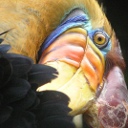

In [113]:
from IPython.display import Image
Image(filename='data/bird_small.png', width=300)

原始像素数据已经准备好了，让我们加载进来吧：

In [114]:
image_data = loadmat('data/bird_small.mat')
type(image_data)

dict

In [115]:
A = image_data['A']
A.shape

(128, 128, 3)

现在我们需要对数据应用一些预处理，并将其提供给K-means算法。

In [116]:
# 数据归一化
A = A / 255.

# reshape the array
X = np.reshape(A, (A.shape[0] * A.shape[1], A.shape[2]))
X.shape

(16384, 3)

In [117]:
# 随机初始化聚类中心
initial_centroids = init_centroids(X, 16)

# 执行K-means算法
idx, centroids_iter = run_k_means(X, initial_centroids, 10)
centroids = centroids_iter[-1]

# 获取最近的聚类中心
idx = find_closest_centroids(X, centroids)

# 把每个像素映射到聚类中心
X_recovered = centroids[idx.astype(int),:]
X_recovered.shape

(16384, 3)

In [118]:
# reshape 成原始维度
X_recovered = np.reshape(X_recovered, (A.shape[0], A.shape[1], A.shape[2]))
X_recovered.shape

(128, 128, 3)

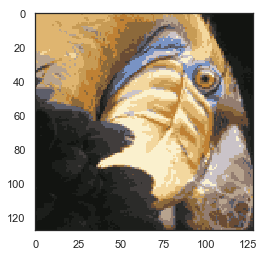

In [119]:
plt.imshow(X_recovered)
plt.show()

您可以看到我们对图像进行了压缩，但图像的主要特征仍然存在。 这就是K-means。 下面我们来用scikit-learn来实现K-means。

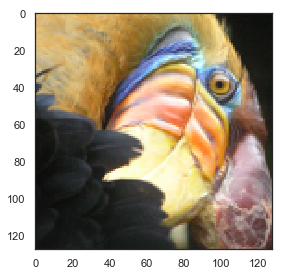

In [120]:
from skimage import io

# 数据归一化
pic = io.imread('data/bird_small.png') / 255.
io.imshow(pic)
plt.show()

In [121]:
pic.shape

(128, 128, 3)

In [122]:
# reshape数据
data = pic.reshape(128*128, 3)
data.shape

(16384, 3)

In [123]:
from sklearn.cluster import KMeans#导入kmeans库

model = KMeans(n_clusters=16, n_init=100, n_jobs=-1)

In [124]:
model.fit(data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=16, n_init=100, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [125]:
centroids = model.cluster_centers_
print(centroids.shape)

C = model.predict(data)
print(C.shape)

(16, 3)
(16384,)


In [126]:
centroids[C].shape

(16384, 3)

In [127]:
compressed_pic = centroids[C].reshape((128,128,3))

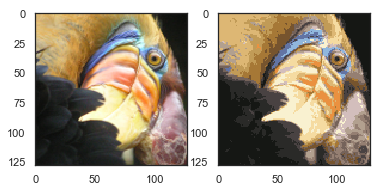

In [128]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(pic)
ax[1].imshow(compressed_pic)
plt.show()

## 2 Principal component analysis（主成分分析）

PCA是在数据集中找到“主成分”或最大方差方向的线性变换。 它可以用于降维。 在本练习中，我们首先负责实现PCA并将其应用于一个简单的二维数据集，以了解它是如何工作的。 我们从加载和可视化数据集开始。

### 2.1 数据集

In [129]:
data = loadmat('data/ex7data1.mat')

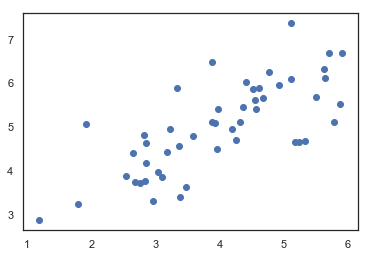

In [130]:
X = data['X']

fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1])
plt.show()

### 2.2 实现PCA

PCA的算法相当简单。 在确保数据被归一化之后，输出仅仅是原始数据的协方差矩阵的奇异值分解。

In [131]:
def pca(X):
    # 归一化数据 normalize the features
    X = (X - X.mean()) / X.std()
    
    # 计算协方差矩阵 covariance matrix
    X = np.matrix(X)
    cov = (X.T * X) / X.shape[0]
    
    # 执行 SVD
    U, S, V = np.linalg.svd(cov)
    
    return U, S, V

In [132]:
U, S, V = pca(X)
U, S, V

(matrix([[-0.79241747, -0.60997914],
         [-0.60997914,  0.79241747]]),
 array([1.43584536, 0.56415464]),
 matrix([[-0.79241747, -0.60997914],
         [-0.60997914,  0.79241747]]))

### 2.3 用PCA降低维度

现在我们有主成分（矩阵U），我们可以用这些来将原始数据投影到一个较低维的空间中。 对于这个任务，我们将实现一个计算投影并且仅选择顶部K个分量的函数，有效地减少了维数。

#### 2.3.1 把数据映射到主成分上

In [133]:
def project_data(X, U, k):
    U_reduced = U[:,:k]
    return np.dot(X, U_reduced)

In [134]:
Z = project_data(X, U, 1)

#### 2.3.2 恢复数据
我们也可以通过反向转换步骤来恢复原始数据。

In [135]:
def recover_data(Z, U, k):
    U_reduced = U[:,:k]
    return np.dot(Z, U_reduced.T)

In [136]:
X_recovered = recover_data(Z, U, 1)

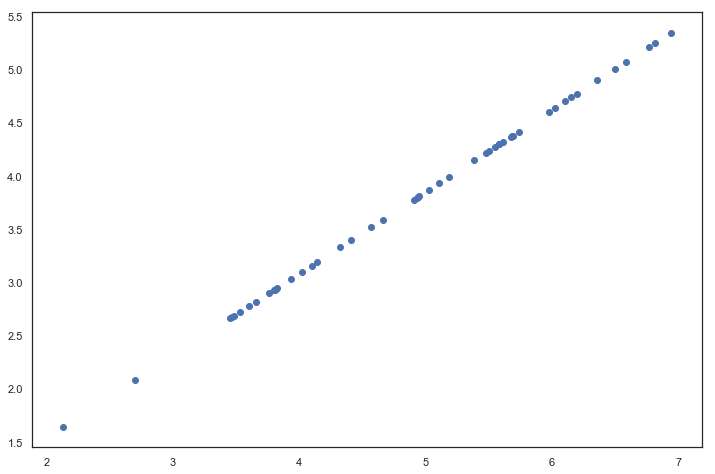

In [137]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(list(X_recovered[:, 0]), list(X_recovered[:, 1]))
plt.show()

请注意，第一主成分的投影轴基本上是数据集中的对角线。 当我们将数据减少到一个维度时，我们失去了该对角线周围的变化，所以在我们的再现中，一切都沿着该对角线。

### 2.4 人脸图像数据集

我们在此练习中的最后一个任务是将PCA应用于脸部图像。 通过使用相同的降维技术，我们可以使用比原始图像少得多的数据来捕获图像的“本质”。

In [138]:
faces = loadmat('data/ex7faces.mat')
X = faces['X']
X.shape

(5000, 1024)

In [139]:
def plot_n_image(X, n):
    """ plot first n images
    n has to be a square number
    """
    pic_size = int(np.sqrt(X.shape[1]))
    grid_size = int(np.sqrt(n))

    first_n_images = X[:n, :]

    fig, ax_array = plt.subplots(nrows=grid_size, ncols=grid_size,
                                    sharey=True, sharex=True, figsize=(8, 8))

    for r in range(grid_size):
        for c in range(grid_size):
            ax_array[r, c].imshow(first_n_images[grid_size * r + c].reshape((pic_size, pic_size)).T)
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))


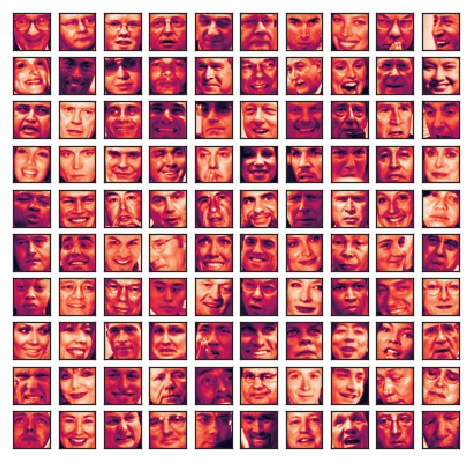

In [140]:
plot_n_image(X, 100)

练习代码包括一个将渲染数据集中的前100张脸的函数。 而不是尝试在这里重新生成，您可以在练习文本中查看他们的样子。 我们至少可以很容易地渲染一个图像。

In [141]:
face = np.reshape(X[3,:], (32, 32)).T

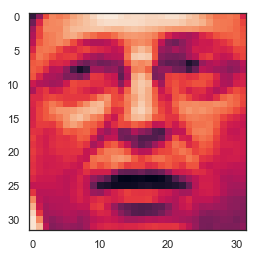

In [142]:
plt.imshow(face)
plt.show()

看起来很糟糕。 这些只有32 x 32灰度的图像（它也是侧面渲染，但我们现在可以忽略）。 我们的下一步是在面数据集上运行PCA，并取得前100个主要特征。

In [143]:
U, S, V = pca(X)
Z = project_data(X, U, 100)

现在我们可以尝试恢复原来的结构并再次渲染。

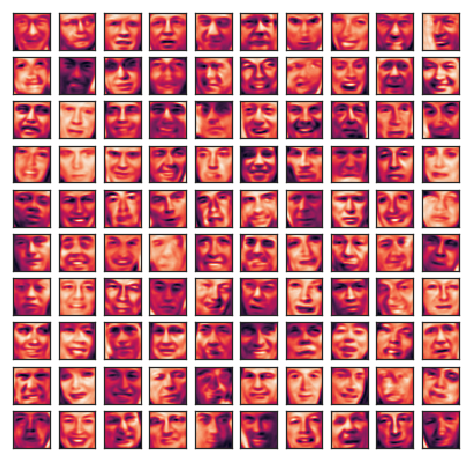

In [144]:
X_recovered = recover_data(Z, U, 100)

plot_n_image(X_recovered, 100)

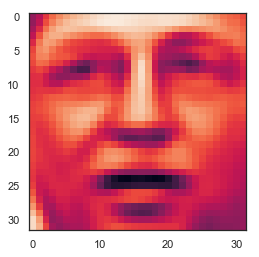

In [145]:
face = np.reshape(X_recovered[3,:], (32, 32)).T
plt.imshow(face)
plt.show()

请注意，我们失去了一些细节，尽管没有像您预期的维度数量减少10倍。
